In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize']=20,10

In [2]:
match_df= pd.read_csv('data/matches.csv')

In [3]:
match_df

,Unnamed: 0,date,time,comp,round,day,venue,result,gf,ga,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
0,0,2022-08-05,20:00,Premier League,Matchweek 1,Fri,Away,W,2.0,0.0,...,Match Report,NaN,10.0,2.0,14.6,1.0,0.0,0.0,2022,Arsenal
1,1,2022-08-13,15:00,Premier League,Matchweek 2,Sat,Home,W,4.0,2.0,...,Match Report,NaN,19.0,7.0,13.0,0.0,0.0,0.0,2022,Arsenal
2,2,2022-08-20,17:30,Premier League,Matchweek 3,Sat,Away,W,3.0,0.0,...,Match Report,NaN,14.0,6.0,14.8,0.0,0.0,0.0,2022,Arsenal
3,3,2022-08-27,17:30,Premier League,Matchweek 4,Sat,Home,W,2.0,1.0,...,Match Report,NaN,22.0,8.0,15.5,1.0,0.0,0.0,2022,Arsenal
4,4,2022-08-31,19:30,Premier League,Matchweek 5,Wed,Home,W,2.0,1.0,...,Match Report,NaN,22.0,8.0,16.3,1.0,0.0,0.0,2022,Arsenal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,35,2019-04-13,12:30,Premier League,Matchweek 34,Sat,Away,L,0.0,4.0,...,Match Report,NaN,7.0,1.0,18.9,1.0,0.0,0.0,2018,Huddersfield Town
3268,36,2019-04-20,15:00,Premier League,Matchweek 35,Sat,Home,L,1.0,2.0,...,Match Report,NaN,13.0,3.0,18.1,1.0,0.0,0.0,2018,Huddersfield Town
3269,37,2019-04-26,20:00,Premier League,Matchweek 36,Fri,Away,L,0.0,5.0,...,Match Report,NaN,5.0,1.0,21.6,0.0,0.0,0.0,2018,Huddersfield Town
3270,38,2019-05-05,14:00,Premier League,Matchweek 37,Sun,Home,D,1.0,1.0,...,Match Report,NaN,7.0,3.0,19.0,1.0,0.0,0.0,2018,Huddersfield Town


In [4]:
match_df.drop(columns=match_df.columns[0], axis=1, inplace=True)
match_df["sh"] = match_df["sh"].astype(int)
match_df["sot"] = match_df["sot"].astype(int)
match_df["xg"] = match_df["xg"].astype(int)
match_df["xga"] = match_df["xga"].astype(int)

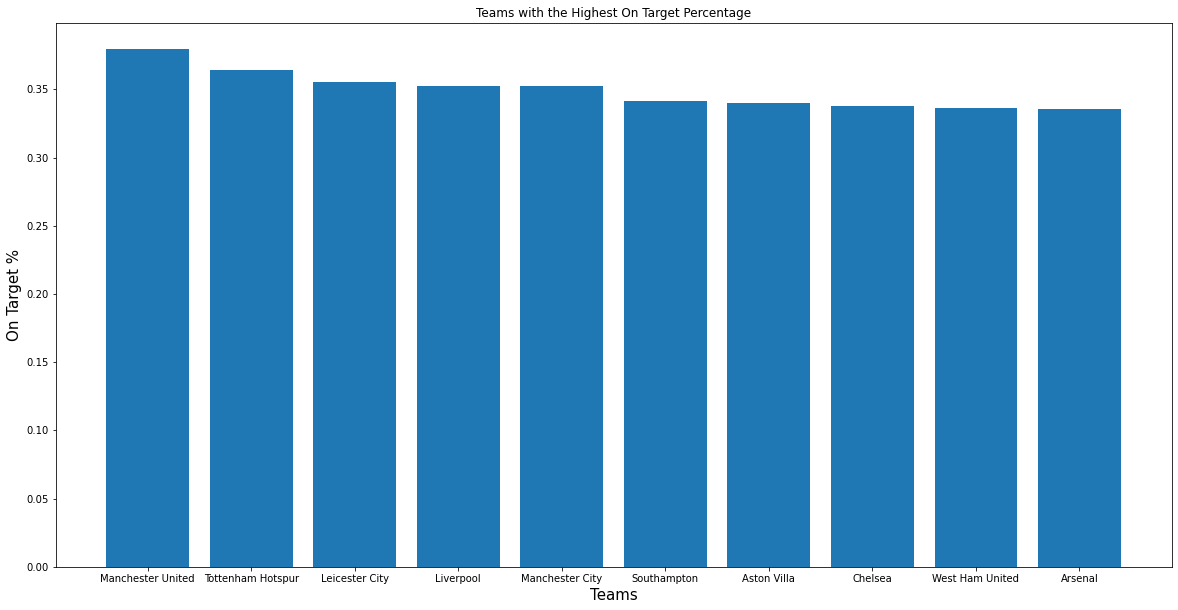

In [5]:
shots_attempted_dict = dict()
shots_on_target_dict = dict()
for curr_indx, curr_row in match_df.iterrows():
    shots_attempted_dict[curr_row["team"]] = shots_attempted_dict.get(curr_row["team"],0) + curr_row["sh"] # find the cumulative shots attempted for all teams
    shots_on_target_dict[curr_row["team"]] = shots_on_target_dict.get(curr_row["team"], 0) + curr_row["sot"] # find the cumulative shots on target for all team

on_target_percentage_dict = dict()
for team in shots_attempted_dict.keys():
    sot = shots_on_target_dict[team]
    sh = shots_attempted_dict[team]
    on_target_percentage_dict[team] = on_target_percentage_dict.get(team, 0.0) + (sot / sh) # on target percentage

on_target_percentage_ranked = dict(sorted(on_target_percentage_dict.items(), key=lambda item: item[1], reverse = True))
pd.DataFrame(on_target_percentage_ranked.items()) # visualize

teams = list(on_target_percentage_ranked.keys())[:10]
on_target_percentage = list(on_target_percentage_ranked.values())[:10]

plt.bar(teams, on_target_percentage)
plt.title('Teams with the Highest On Target Percentage')
plt.xlabel('Teams', fontsize=15)
plt.ylabel('On Target %', fontsize=15)
plt.show()

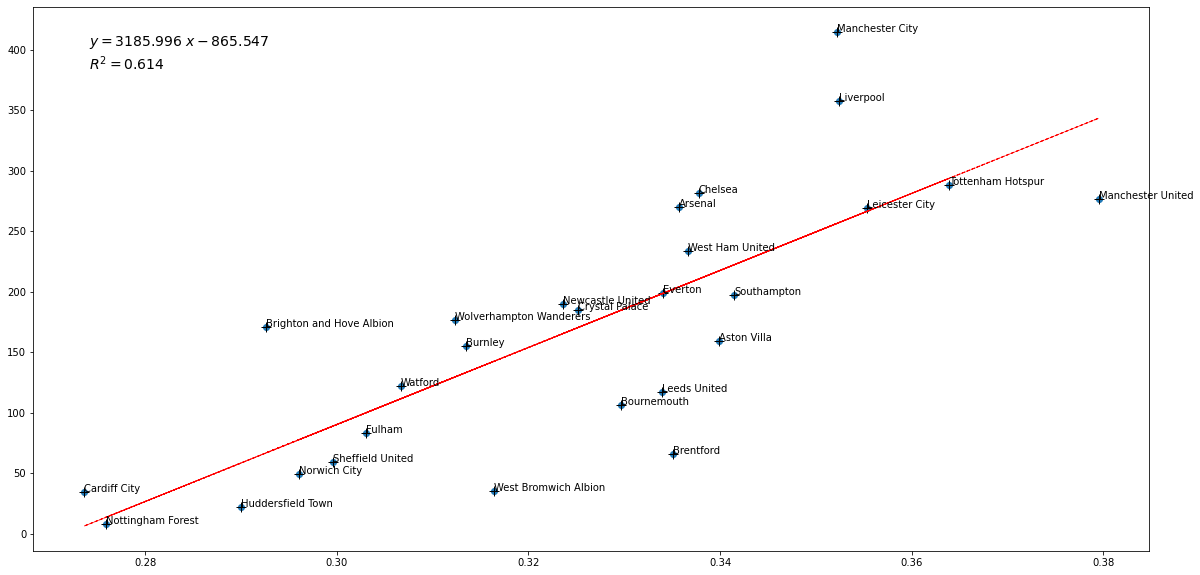

In [6]:
team_goals_dict = dict()
for curr_indx, curr_row in match_df.iterrows():
    team_goals_dict[curr_row["team"]] = team_goals_dict.get(curr_row["team"],0) + curr_row["gf"] # find the cumulative goals made for all teams

y = list(team_goals_dict.values())
x = list(on_target_percentage_dict.values())
teams = list(team_goals_dict.keys())

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, team in enumerate(teams):
    ax.annotate(team, (x[i], y[i]))
    
from sklearn.metrics import r2_score

plt.plot(x,y,"+", ms=10, mec="k")
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.show()

## Positive trend found in on target percentage and total goals made! 

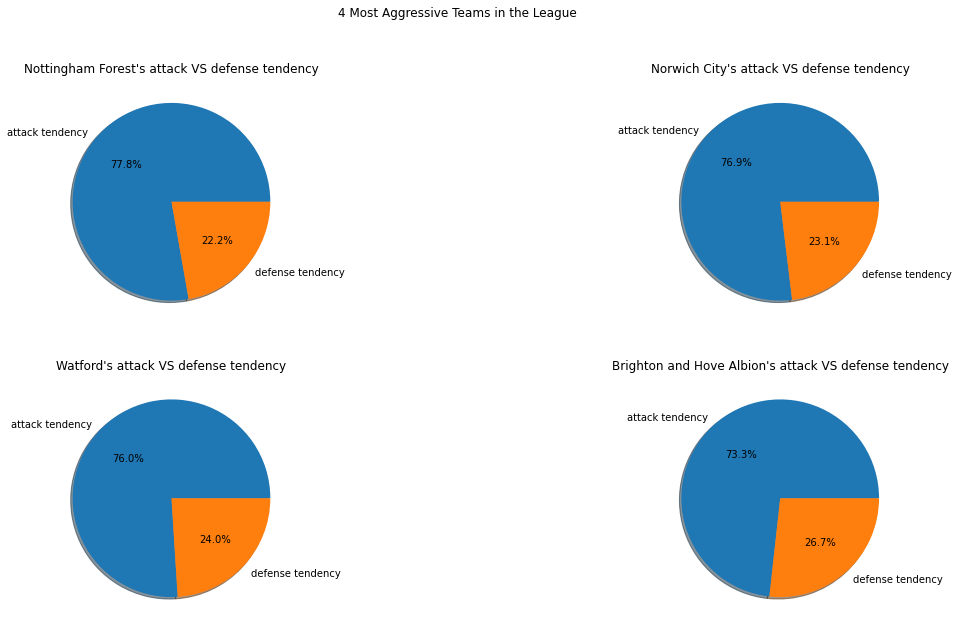

In [7]:
# finding the most aggressive team (prefer attack to defense)
team_xg_dict = dict()
team_xga_dict = dict()
for curr_indx, curr_row in match_df.iterrows():
    team_xg_dict[curr_row["team"]] = team_xg_dict.get(curr_row["team"],0) + curr_row["xg"]
    team_xga_dict[curr_row["team"]] = team_goals_dict.get(curr_row["team"],0) + curr_row["xga"]

tendency_att_dict = dict()
for team in team_xg_dict.keys():
    xg = team_xg_dict[team]
    xga = team_xga_dict[team]
    tendency_att = xg / xga
    tendency_att_dict[team] = tendency_att_dict.get(team,0.0) + tendency_att

tendency_att_ranked = dict(sorted(tendency_att_dict.items(), key=lambda item: item[1], reverse = True))
tendency_att = list(tendency_att_ranked.values())[:4]
tendency_def = []
for tend_att in list(tendency_att_ranked.values()):
    tend_def = 1 - tend_att
    tendency_def.append(tend_def)
tendency_def = tendency_def[:4]

fig, axes = plt.subplots(2,2)

att_def = list()
for i in range(4):
    att_def.append([tendency_att[i], tendency_def[i]])

labels = 'attack tendency', 'defense tendency'
team_names = list(tendency_att_ranked.keys())[:4]
axes[0, 0].pie(att_def[0], labels = labels, autopct='%1.1f%%', shadow=True)
axes[0,0].set_title(team_names[0] + "'s attack VS defense tendency")

axes[0, 1].pie(att_def[1], labels = labels, autopct='%1.1f%%', shadow=True)
axes[0,1].set_title(team_names[1] + "'s attack VS defense tendency")

axes[1, 0].pie(att_def[2], labels = labels, autopct='%1.1f%%', shadow=True)
axes[1,0].set_title(team_names[2] + "'s attack VS defense tendency")

axes[1, 1].pie(att_def[3], labels = labels, autopct='%1.1f%%', shadow=True)
axes[1,1].set_title(team_names[3] + "'s attack VS defense tendency")

fig.suptitle('4 Most Aggressive Teams in the League')

plt.show()

[[0.5, 0.5], [0.5578947368421052, 0.4421052631578948], [0.5591397849462365, 0.4408602150537635], [0.5675675675675675, 0.43243243243243246]]


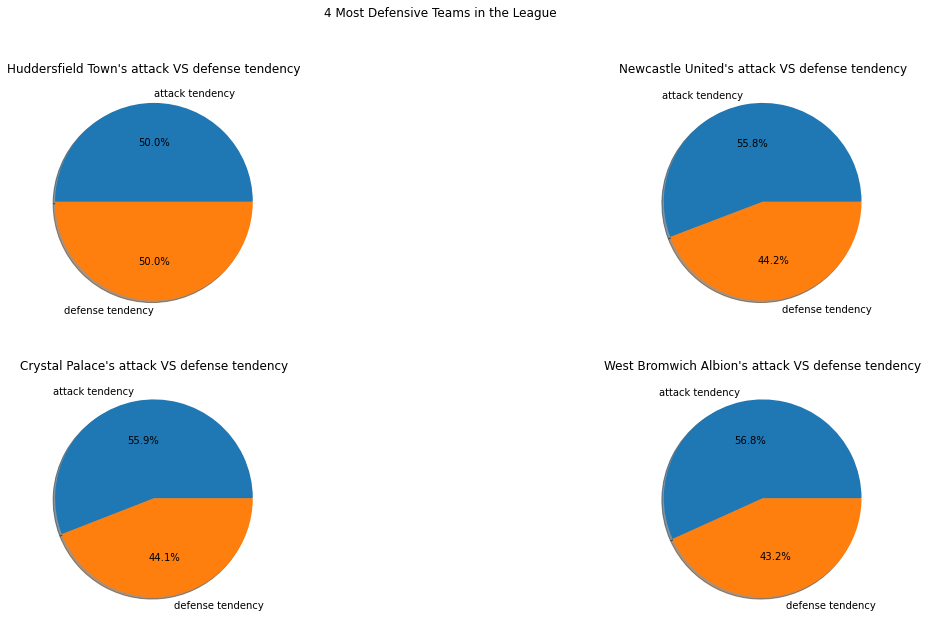

In [8]:
# finding the most defensive team (prefer defense to attack)
tendency_att_ranked = dict(sorted(tendency_att_dict.items(), key=lambda item: item[1], reverse = False))
tendency_att = list(tendency_att_ranked.values())[:4]
tendency_def = []
for tend_att in list(tendency_att_ranked.values()):
    tend_def = 1 - tend_att
    tendency_def.append(tend_def)
tendency_def = tendency_def[:4]

fig, axes = plt.subplots(2,2)

att_def = list()
for i in range(4):
    att_def.append([tendency_att[i], tendency_def[i]])
print(att_def)
labels = 'attack tendency', 'defense tendency'
team_names = list(tendency_att_ranked.keys())[:4]
axes[0, 0].pie(att_def[0], labels = labels, autopct='%1.1f%%', shadow=True)
axes[0,0].set_title(team_names[0] + "'s attack VS defense tendency")

axes[0, 1].pie(att_def[1], labels = labels, autopct='%1.1f%%', shadow=True)
axes[0,1].set_title(team_names[1] + "'s attack VS defense tendency")

axes[1, 0].pie(att_def[2], labels = labels, autopct='%1.1f%%', shadow=True)
axes[1,0].set_title(team_names[2] + "'s attack VS defense tendency")

axes[1, 1].pie(att_def[3], labels = labels, autopct='%1.1f%%', shadow=True)
axes[1,1].set_title(team_names[3] + "'s attack VS defense tendency")

fig.suptitle('4 Most Defensive Teams in the League')

plt.show()